<a href="https://colab.research.google.com/github/sayakpaul/A-B-testing-with-Machine-Learning/blob/master/Skin_Cancer_MNIST_Model_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will be combining the two different models we had built ([tabular model](https://colab.research.google.com/drive/1GB3nuByQFFl64vnltBsz3w6R9YjNjbUz?usp=sharing) and [image model](https://colab.research.google.com/drive/1SDA0zIb93VJitk9RIPP9lOfk8pRsqUB6?usp=sharing)) for handling two different input modalities - tabular data and images. EDA notebook can be viewed [here](https://colab.research.google.com/drive/1c8OqgWXTTrsI4X8_lhLBZ37ryEoRleY-?usp=sharing). 

I used [our tutorial on handling multiple input modalities](https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/) as the major point of reference. 

The dataset we are using here [is available on Kaggle](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000). 

### Initial setup

In [1]:
!nvidia-smi

Thu Oct 22 01:35:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [01:48<00:00, 31.9MB/s]
100% 5.20G/5.20G [01:48<00:00, 51.3MB/s]


### Imports

In [5]:
!unzip -qq skin-cancer-mnist-ham10000.zip

In [6]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import glob
import os

tf.random.set_seed(42)
np.random.seed(42)

### Gather extra metadata

In [8]:
!cp -r /content/drive/My\ Drive/Skin_Cancer_MNIST/df_*.csv .

In [9]:
data_train = pd.read_csv("df_train.csv")
data_valid = pd.read_csv("df_val.csv")

### Preprocess the patient metadata

In [10]:
image_paths_train = data_train["path"].values
image_paths_valid = data_valid["path"].values

len(image_paths_train), len(image_paths_valid)

(8512, 1503)

In [11]:
columns_to_drop = ['lesion_id', 'image_id', 'dx','cell_type', 'path']
data_train = data_train.drop(columns_to_drop, axis=1)
data_valid = data_valid.drop(columns_to_drop, axis=1)

In [12]:
data_train["age"].fillna(data_train["age"].mean(), inplace=True)
data_valid["age"].fillna(data_train["age"].mean(), inplace=True)

In [13]:
le = LabelEncoder()

# Iterate over all the values of each column and extract their dtypes
for col in data_train.columns.values:
    # Compare if the dtype is object
    if data_train[col].dtypes=='object':
    # Use LabelEncoder to do the numeric transformation
        le.fit(data_train[col])
        data_train[col] = le.transform(data_train[col])
        data_valid[col] = le.transform(data_valid[col])

In [14]:
X_train = data_train[data_train.columns[:-1]].values
X_valid = data_valid[data_valid.columns[:-1]].values

y_train = data_train[data_train.columns[-1]].values
y_valid = data_valid[data_valid.columns[-1]].values

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((8512, 4), (1503, 4), (8512,), (1503,))

In [15]:
categorical_variables = ['dx_type', 'sex', 'localization']
cat_sizes = {}
cat_embsizes = {}
for cat in categorical_variables:
    cat_sizes[cat] = data_train[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)

cat_embsizes

{'dx_type': 3, 'localization': 8, 'sex': 2}

### Preprocessing utils

In [16]:
IMG_SHAPE = 224

def parse_images(image_path):
    # Load and preprocess the image
    img = tf.io.read_file(image_path) # read the raw image
    img = tf.image.decode_jpeg(img, channels=3) # decode the image back to proper format
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE]) # resize the image

    return img

def segregate_inputs(X):
    dx_type = X[:, 0].reshape(-1, 1)
    sex = X[:, 2].reshape(-1, 1)
    localization = X[:, 3].reshape(-1, 1)

    return dx_type, sex, localization

In [17]:
# Segregate the three different categorical variables in a way
# our model would expect
X_train_dt, X_train_sex, X_train_loc = segregate_inputs(X_train)
X_valid_dt, X_valid_sex, X_valid_loc = segregate_inputs(X_valid)

# scale the age values
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train[:, 1].reshape(-1, 1))
age_train_scaled = scaler.transform(X_train[:, 1].reshape(-1, 1))
age_valid_scaled = scaler.transform(X_valid[:, 1].reshape(-1, 1))

### Create TensorFlow datasets for model training

In [22]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

# Create TensorFlow dataset for the patient metadata
train_ds_metadata = tf.data.Dataset.from_tensor_slices((X_train_dt, X_train_sex, X_train_loc, age_train_scaled))
valid_ds_metadata = tf.data.Dataset.from_tensor_slices((X_valid_dt, X_valid_sex, X_valid_loc, age_valid_scaled))


# Create TensorFlow dataset for the images
train_ds_images = tf.data.Dataset.from_tensor_slices(image_paths_train).map(parse_images, num_parallel_calls=AUTO)
valid_ds_images = tf.data.Dataset.from_tensor_slices(image_paths_valid).map(parse_images, num_parallel_calls=AUTO)

In [23]:
y_train_ohe = tf.keras.utils.to_categorical(y_train, 7)
y_valid_ohe = tf.keras.utils.to_categorical(y_valid, 7)

y_train_ds = tf.data.Dataset.from_tensor_slices(y_train_ohe)
y_valid_ds = tf.data.Dataset.from_tensor_slices(y_valid_ohe)

As we are using multiple data generators we need to zip them together in the following way - 
- `(train_ds_metadata, train_ds_images)` denotes the input features i.e. the patient metadata and images.
- `y_train_ds` denotes labels. 

In [24]:
train_loader = tf.data.Dataset.zip(((train_ds_metadata, train_ds_images), y_train_ds))
valid_loader = tf.data.Dataset.zip(((valid_ds_metadata, valid_ds_images), y_valid_ds))

train_loader = (
    train_loader
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

valid_loader = (
    valid_loader
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

### Data augmentation layers and plotting utils

In [25]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [26]:
def plot_progress(hist):
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="validation_loss")
    plt.plot(hist.history["accuracy"], label="training_accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation_accuracy")
    plt.title("Training Progress")
    plt.ylabel("accuracy/loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.show()

### Model building 

Note that the following Xception-based model has been referred from [here](https://keras.io/guides/transfer_learning/). The model including entity embeddings has been referred from [here](https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9). 

In [27]:
def get_image_model():
    base_model = tf.keras.applications.Xception(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=(224, 224, 3),
        include_top=False,
    )  # Do not include the ImageNet classifier at the top.

    # Freeze the base_model
    base_model.trainable = True

    # Create new model on top
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)  # Apply random data augmentation

    # Pre-trained Xception weights requires that input be normalized
    # from (0, 255) to a range (-1., +1.), the normalization layer
    # does the following, outputs = (inputs - mean) / sqrt(var)
    norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
    mean = np.array([127.5] * 3)
    var = mean ** 2
    # Scale inputs to [-1, +1]
    x = norm_layer(x)
    norm_layer.set_weights([mean, var])

    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = tf.keras.layers.Dense(25, activation="relu", kernel_initializer="he_normal")(x)
    model = tf.keras.Model(inputs, outputs)

    return model

def get_metadata_model(pre_final_neurons=25):
    ins = []
    concat = []

    for cat in categorical_variables:
        x = Input((1,), name=cat)
        ins.append(x)
        x = Embedding(cat_sizes[cat]+1, cat_embsizes[cat], input_length=1)(x)
        x = Reshape((cat_embsizes[cat],))(x)
        concat.append(x)

    age = Input((1, ), name='age')
    ins.append(age)
    concat.append(age)

    y = Concatenate()(concat)
    y = Dense(pre_final_neurons, activation='relu', kernel_initializer='he_normal')(y)
    model = Model(ins, y)

    return model

In [28]:
def get_multi_modal_model():
    mlp = get_metadata_model()
    cnn = get_image_model()

    concatenated = concatenate([mlp.output, cnn.output])

    outputs = Dense(len(np.unique(y_train)), activation="softmax")(concatenated)
    model = Model(inputs=[mlp.input, cnn.input], outputs=outputs)

    return model

83689472/83683744 [==============================] - 0s 0us/step


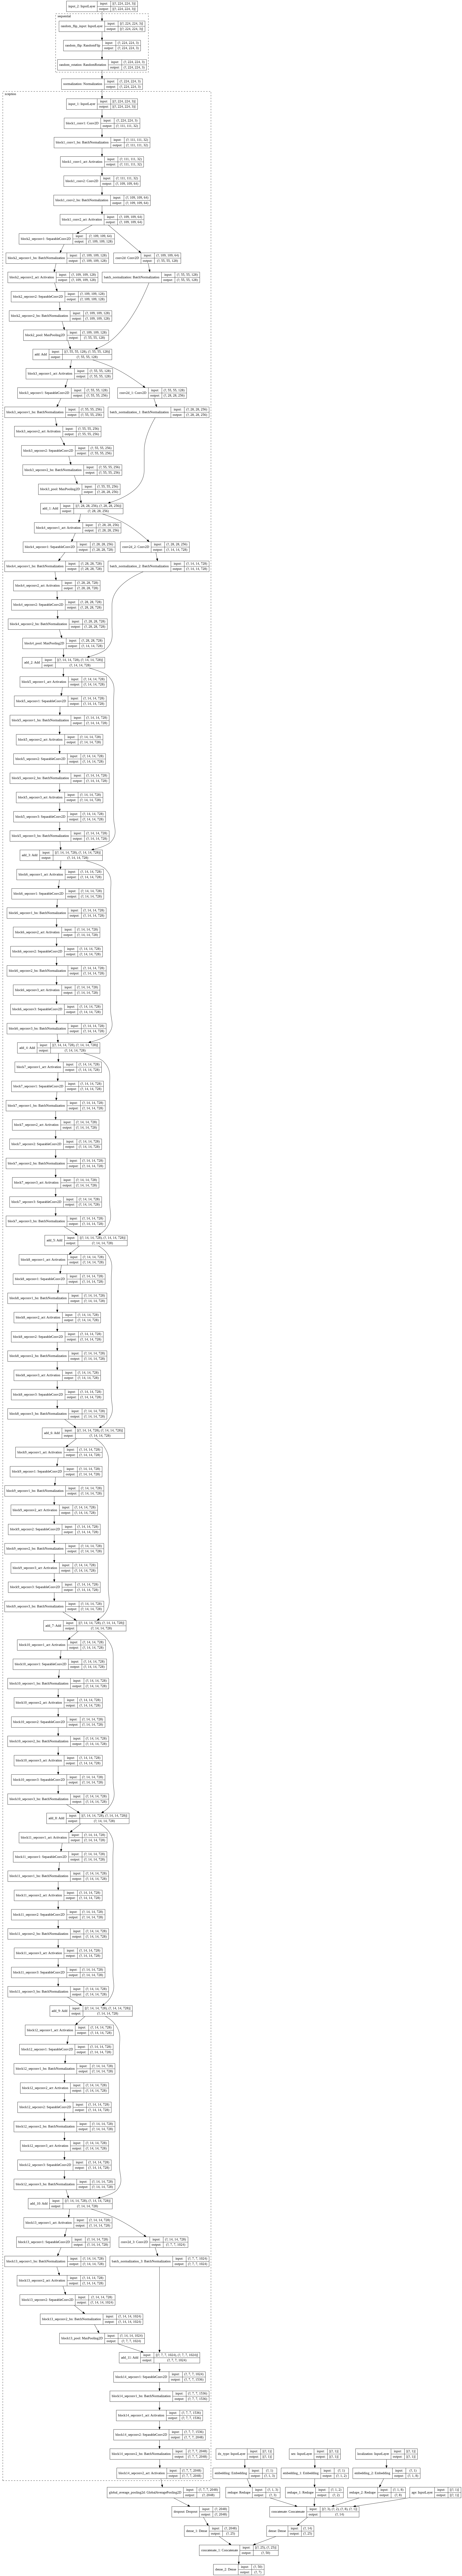

In [29]:
tf.keras.utils.plot_model(get_multi_modal_model(), show_shapes=True, expand_nested=True)

In [31]:
model = get_multi_modal_model()
print("Model inputs:", model.input)
print("Model outputs:", model.output)

Model inputs: [[<tf.Tensor 'dx_type_2:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'sex_2:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'localization_2:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'age_2:0' shape=(None, 1) dtype=float32>], <tf.Tensor 'input_6:0' shape=(None, 224, 224, 3) dtype=float32>]
Model outputs: Tensor("dense_8/Softmax:0", shape=(None, 7), dtype=float32)


### Model training and evaluation

Epoch 1/20
133/133 [==============================] - 183s 1s/step - loss: 0.8741 - accuracy: 0.6926 - val_loss: 0.7089 - val_accuracy: 0.7405
Epoch 2/20
133/133 [==============================] - 175s 1s/step - loss: 0.6399 - accuracy: 0.7689 - val_loss: 0.6218 - val_accuracy: 0.7745
Epoch 3/20
133/133 [==============================] - 175s 1s/step - loss: 0.5009 - accuracy: 0.8141 - val_loss: 0.4838 - val_accuracy: 0.8310
Epoch 4/20
133/133 [==============================] - 175s 1s/step - loss: 0.4321 - accuracy: 0.8414 - val_loss: 0.5022 - val_accuracy: 0.8257
Epoch 5/20
133/133 [==============================] - 175s 1s/step - loss: 0.3433 - accuracy: 0.8766 - val_loss: 0.5077 - val_accuracy: 0.8317
Epoch 6/20
133/133 [==============================] - 175s 1s/step - loss: 0.2852 - accuracy: 0.8953 - val_loss: 0.5479 - val_accuracy: 0.8204
Epoch 7/20
133/133 [==============================] - 175s 1s/step - loss: 0.2508 - accuracy: 0.9081 - val_loss: 0.4457 - val_accuracy: 0.8430

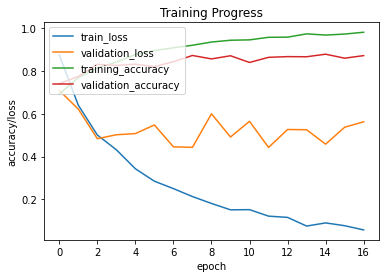

In [32]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

model = get_multi_modal_model()
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"])
history = model.fit(train_loader,
    validation_data=valid_loader,
    epochs=20,
    callbacks=[es])
plot_progress(history)

In [34]:
labels = []
for (_, _), label_batch in valid_loader:
    for label in label_batch:
        labels.append(label)

labels = np.array(labels)
labels.shape

(1503, 7)

In [35]:
predictions = model.predict(valid_loader).argmax(axis=1)
print(classification_report(labels.argmax(axis=1), predictions))

              precision    recall  f1-score   support

           0       0.76      0.59      0.67        49
           1       0.83      0.69      0.75        77
           2       0.81      0.68      0.74       165
           3       0.88      0.88      0.88        17
           4       0.92      0.95      0.93      1006
           5       0.91      0.91      0.91        22
           6       0.64      0.69      0.66       167

    accuracy                           0.86      1503
   macro avg       0.82      0.77      0.79      1503
weighted avg       0.86      0.86      0.86      1503



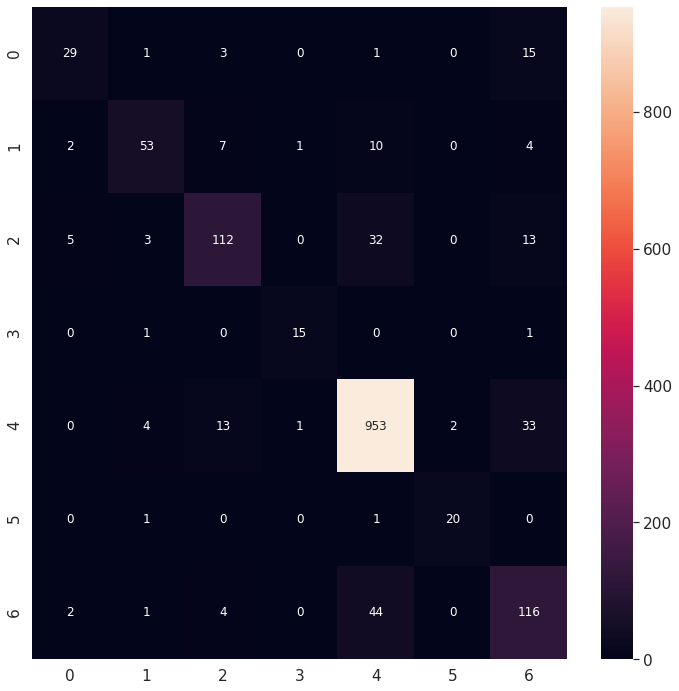

In [36]:
cm = confusion_matrix(labels.argmax(axis=1), predictions)

# https://stackoverflow.com/a/42265865/7636462
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 12}) # font size
plt.show()

In [38]:
# calculate the total number of images in each class and
# initialize a dictionary to store the class weights
classTotals = y_train_ohe.sum(axis=0)
classWeight = dict()

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

classWeight

{0: 20.5,
 1: 13.04119,
 2: 6.101713,
 3: 58.15306,
 4: 1.0,
 5: 47.491665,
 6: 6.024313}

Epoch 1/20
133/133 [==============================] - 177s 1s/step - loss: 8.7366 - accuracy: 0.2909 - val_loss: 1.8152 - val_accuracy: 0.3819
Epoch 2/20
133/133 [==============================] - 174s 1s/step - loss: 6.3067 - accuracy: 0.5172 - val_loss: 0.9005 - val_accuracy: 0.6833
Epoch 3/20
133/133 [==============================] - 175s 1s/step - loss: 4.6846 - accuracy: 0.5905 - val_loss: 0.7766 - val_accuracy: 0.6747
Epoch 4/20
133/133 [==============================] - 175s 1s/step - loss: 4.2058 - accuracy: 0.6349 - val_loss: 0.8485 - val_accuracy: 0.6401
Epoch 5/20
133/133 [==============================] - 175s 1s/step - loss: 3.3171 - accuracy: 0.6961 - val_loss: 0.8984 - val_accuracy: 0.6347
Epoch 6/20
133/133 [==============================] - 176s 1s/step - loss: 3.0653 - accuracy: 0.7048 - val_loss: 0.8654 - val_accuracy: 0.6633
Epoch 7/20
133/133 [==============================] - 176s 1s/step - loss: 2.4693 - accuracy: 0.7330 - val_loss: 0.5960 - val_accuracy: 0.7631

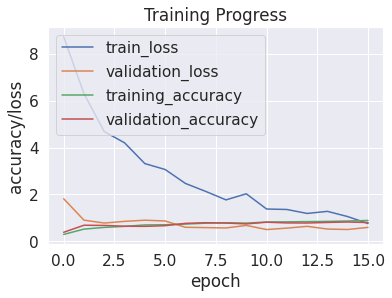

In [39]:
model = get_multi_modal_model()
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"])
history = model.fit(train_loader,
    validation_data=valid_loader,
    epochs=20,
    class_weight=classWeight,
    callbacks=[es])
plot_progress(history)

In [40]:
predictions = model.predict(valid_loader).argmax(axis=1)
print(classification_report(labels.argmax(axis=1), predictions))

              precision    recall  f1-score   support

           0       0.74      0.47      0.58        49
           1       0.74      0.78      0.76        77
           2       0.66      0.77      0.71       165
           3       0.75      0.88      0.81        17
           4       0.95      0.85      0.90      1006
           5       0.91      0.91      0.91        22
           6       0.47      0.74      0.58       167

    accuracy                           0.81      1503
   macro avg       0.75      0.77      0.75      1503
weighted avg       0.85      0.81      0.82      1503



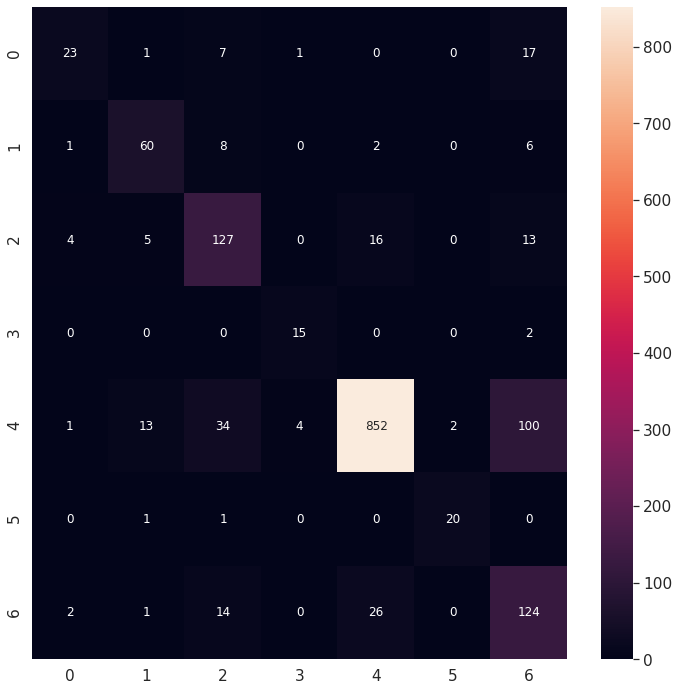

In [41]:
cm = confusion_matrix(labels.argmax(axis=1), predictions)
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 12}) # font size
plt.show()